In [1]:
import json
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
scenario = "figurative"

In [3]:
identify_explain = "/identify_explain_"
autistic_chances = "/autistic_chances_"
non_autistic_chances = "/non_autistic_chances_"

ctx_none = "ctx_none.json"
ctx_autism = "ctx_autism.json"
ctx_neuro = "ctx_neuro.json"
ctx_all = "ctx_all.json"



file_dir = "../../"+scenario+"_analysis_data"

In [4]:
with open(file_dir+identify_explain+ctx_none, "r") as f:
    none_data = json.load(f)
with open(file_dir+identify_explain+ctx_autism, "r") as f:
    autism_data = json.load(f)
with open(file_dir+identify_explain+ctx_neuro, "r") as f:
    neuro_data = json.load(f)
with open(file_dir+identify_explain+ctx_all, "r") as f:
    all_data = json.load(f)

In [5]:
valid = {"neither", "both", "speaker 1", "speaker 2"}

def get_fault(d):
    """Return normalized 'fault' or None if missing/invalid."""
    if not isinstance(d, dict):
        return None
    v = d.get("fault")
    if not isinstance(v, str):
        return None
    v = v.strip().lower()
    return v if v in valid else None

# Align by index; keep only indices where ALL four are valid
n = min(len(none_data), len(autism_data), len(neuro_data), len(all_data))
pairs = []
for i in range(n):
    a = get_fault(none_data[i])
    b = get_fault(autism_data[i])
    c = get_fault(neuro_data[i])
    d = get_fault(all_data[i])
    if None not in (a, b, c, d):
        pairs.append((a, b, c, d))

none_clean  = [p[0] for p in pairs]
autism_clean = [p[1] for p in pairs]
neuro_clean  = [p[2] for p in pairs]
all_clean    = [p[3] for p in pairs]

print("Total indices considered:", n)
print("Valid, aligned indices kept:", len(pairs))
print("Dropped:", n - len(pairs))

Total indices considered: 100
Valid, aligned indices kept: 100
Dropped: 0


In [6]:
df = pd.DataFrame({
    "none": none_clean,
    "autism": autism_clean,
    "neuro": neuro_clean,
    "all": all_clean,
})
df.head()

,none,autism,neuro,all
0,speaker 2,speaker 2,speaker 2,neither
1,neither,neither,neither,neither
2,speaker 2,neither,neither,neither
3,speaker 2,neither,neither,neither
4,speaker 2,neither,neither,neither


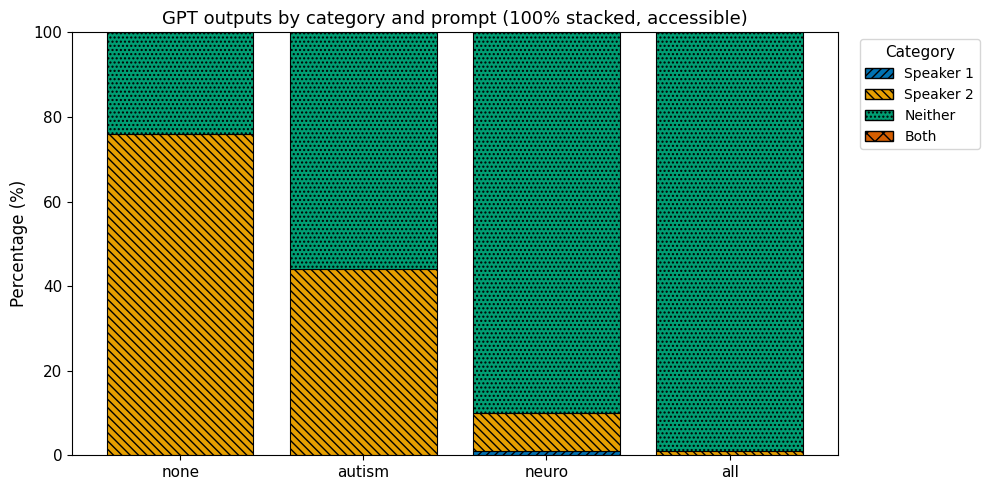

In [9]:


cats = valid
df_cat = df.apply(lambda col: pd.Categorical(col, categories=cats, ordered=True))
counts_df = df_cat.apply(lambda s: s.value_counts()).reindex(cats)
prompts = counts_df.columns.tolist()
perc_df = counts_df.div(counts_df.sum(axis=0), axis=1) * 100

# Colorblind-safe (Okabe–Ito) — 4 distinct hues
palette = ["#0072B2", "#E69F00", "#009E73", "#D55E00"]  # blue, orange, green, red
# Matching hatch patterns (high contrast in grayscale)
hatches = ["////", "\\\\\\\\", "....", "xx"]

plt.figure(figsize=(10, 5))

bottom = np.zeros(len(prompts))
handles = []

for i, cat in enumerate(cats):
    vals = perc_df.loc[cat].values
    bars = plt.bar(
        prompts, vals,
        bottom=bottom,
        label=cat.title(),
        color=palette[i],
        hatch=hatches[i],
        edgecolor="black",
        linewidth=0.8
    )
    bottom += vals
    # legend handle with same styling
    handles.append(Patch(facecolor=palette[i], hatch=hatches[i], edgecolor="black", label=cat.title()))

plt.ylabel("Percentage (%)", fontsize=12)
plt.title("GPT outputs by category and prompt (100% stacked, accessible)", fontsize=13)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.ylim(0, 100)
plt.legend(handles=handles, title="Category", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()
